In [44]:
# Importing required packages
import glob
from operator import contains
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.15f}'.format


In [2]:
def isNaN(string):
    return string != string

def remove_file(file_name):
    if os.path.exists(file_name):
        os.remove(file_name)
    else:
        print("The file does not exist")

def extract_attacker_senders(df, attacker_type):
    """This function can be used to to list/extract attackers based on sender
    input: 
        df: pandas.Dataframe
            Data which needs to processed to extract attackers
        attacker_type: str
            type which identifies attacker eg: '5' for constant speed attack
    returns:
        list
            a list of unique attackers
    """
    # Checking if filename has attacker type and then extracting sender corresponding to that row
    attacker_senders = np.where(df['file_name'].str.extract(r'A(\d)') == attacker_type, (df['file_name'].str.extract(r'traceJSON-(\d*)-')).astype(int), np.nan)
    # reomving nan values
    attacker_senders =  [value for value in attacker_senders if not isNaN(value[0])]
    # As we get it as nested array, flattening it
    flat_attacker_senders = [item for sub_list in attacker_senders for item in sub_list]
    # removing the duplicate senders in the attackers list
    unique_attacker_senders = list(set(flat_attacker_senders))
    print('size of unique_attacker_senders')
    print(len(unique_attacker_senders))
    return unique_attacker_senders

In [3]:
def extract_type_3_data_as_csv(file_location, density_level, export_file_name = 'exported_type_3_'+ str(datetime.now(tz=None))):
    """This function can be used to to extract type 3 data from received messages in json format and export as csv
    input: 
        file_location: str
            location/folder which contains the json files
        export_file_name: str
            file name including path to be used for exporting data as csv
    """
    try:
        # reading the json files
        # traceJSON-21-19-A0-50408-14
        # files = glob.glob(file_location + '/traceJSON-21-19-A0-50408-14.json')
        files = glob.glob(file_location + '/traceJSON-*.json')
        # print(len(files))
        data = pd.concat([pd.read_json(fp, lines=True).assign(file_name=os.path.basename(fp).split('.')[0], density_level=density_level) 
            for fp in files])
        print('Shape of Data before extraction')
        print(data.shape)
        type_3_data=data[data["type"]==3]
        type_3_data.reset_index(drop=True, inplace=True)
        # type_3_data=type_3_data[type_3_data["messageID"]==17018]
        print('Shape of Data after type 3 extraction')
        print(type_3_data.shape)
        print(type_3_data.head())
        # Creating new features from existing feature for spatial data
        columns_to_split = ['pos','pos_noise','spd','spd_noise','acl','acl_noise','hed','hed_noise']
        for column in columns_to_split:
            new_column_df = pd.DataFrame(type_3_data[column].to_list(), columns=[column + '_x', column + '_y', column + '_z'])
            type_3_data[column + '_x'] = new_column_df[column + '_x']
            type_3_data[column + '_y'] = new_column_df[column + '_y']
            type_3_data[column + '_z'] = new_column_df[column + '_z']
        # droping old column as we have created new features
        type_3_data.drop(columns = columns_to_split, inplace = True)
        attacker_senders = extract_attacker_senders(type_3_data, '5')
        type_3_data['attack?'] = np.where(type_3_data['sender'].isin(attacker_senders), 1, 0)

        type_3_data['receiver_id'] = type_3_data['file_name'].str.extract(r'traceJSON-(?P<receiver_id>\d*)')
        print('Shape of Data after feature engineering')
        # Write data to csv for further usage
        # removing existing file
        # remove_file(export_file_name)
        # type_3_data.to_csv(export_file_name,index=False, encoding='utf-8')
        return type_3_data
    except Exception as ex:
        print(ex)
file_location = 'C:/Users/CJ/'
combined_df = []

In [4]:
# Data extraction
extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_25200_28800_2019-11-27_16-27-57.tar/VeReMi_25200_28800_2019-11-27_16_27_57',1,file_location + 'C:/Users/CJ/ConstSpeed_0709_25200_28800_2019-11-27_16_27_57.csv')
# extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_28800_32400_2019-11-27_16-27-57.tar/VeReMi_28800_32400_2019-11-27_16_27_57',1,'C:/Users/CJ/VeReMi_28800_32400_2019-11-27_16_27_57.csv')
# extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_50400_54000_2019-11-28_10-42-1.tar/VeReMi_50400_54000_2019-11-28_10_42_1',2,'C:/Users/CJ/VeReMi_50400_54000_2019-11-28_10_42_1.csv')
# extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_54000_57600_2019-11-28_10-42-1.tar/VeReMi_54000_57600_2019-11-28_10_42_1',2,'C:/Users/CJ/VeReMi_54000_57600_2019-11-28_10_42_1,2.csv')


# Data extraction
combined_df.append(extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_25200_28800_2019-11-27_16-27-57.tar/VeReMi_25200_28800_2019-11-27_16_27_57',1,
 file_location + 'ConstSpeed_0709_25200_28800_2019-11-27_16_27_57.csv'))
combined_df.append(extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_28800_32400_2019-11-27_16-27-57.tar/VeReMi_28800_32400_2019-11-27_16_27_57',1,
 file_location + 'ConstSpeed_0709_28800_32400_2019-11-27_16_27_57.csv'))
combined_df.append(extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_50400_54000_2019-11-28_10-42-1.tar/VeReMi_50400_54000_2019-11-28_10_42_1',2,
 file_location + 'ConstSpeed_1416_54000_57600_2019-11-28_10_42_1.csv'))
combined_df.append(extract_type_3_data_as_csv('C:/Users/CJ/Downloads/VeReMi_54000_57600_2019-11-28_10-42-1.tar/VeReMi_54000_57600_2019-11-28_10_42_1',2,
 file_location + 'ConstSpeed_1416_50400_54000_2019-11-28_10_42_1.csv'))
result = pd.concat(combined_df)
print(result.info())
# result.to_csv('C:/Users/CJ/final.csv',index=False, encoding='utf-8')



Shape of Data before extraction
(1429184, 16)
Shape of Data after type 3 extraction
(1232406, 16)
   type               rcvTime                                            pos  \
0     3 28479.023478335719119  [217.53899068610872, 387.23086950085894, 0.0]   
1     3 28479.053588483031490  [252.77864302274384, 170.11956570046846, 0.0]   
2     3 28479.058563142312778   [225.2687146871083, 418.05015794941676, 0.0]   
3     3 28479.140509144130192   [222.81900508376503, 411.5742392200009, 0.0]   
4     3 28479.172717155321152    [225.858877369055, 412.12411064451373, 0.0]   

                                     pos_noise  \
0  [4.683785841014807, 4.439852205830439, 0.0]   
1    [3.867990760746391, 3.6556703477888, 0.0]   
2  [4.347004518311766, 4.118059940360302, 0.0]   
3  [3.040431174850027, 3.148241796427938, 0.0]   
4  [3.5363279009740722, 3.59082826865462, 0.0]   

                                                 spd  \
0   [-0.06590319950498401, 0.44364651708079605, 0.0]   
1      [

size of unique_attacker_senders
666
Shape of Data after feature engineering
Shape of Data before extraction
(684869, 16)
Shape of Data after type 3 extraction
(569173, 16)
   type               rcvTime                                            pos  \
0     3 50857.177326108838315   [282.0187031067261, 227.98653618210218, 0.0]   
1     3 50857.634317323791038  [247.46179590625607, 208.90178677796828, 0.0]   
2     3 50857.833874415817263    [252.1450189110736, 220.6528491424593, 0.0]   
3     3 50858.177328559424495     [295.5585668848796, 232.216711822555, 0.0]   
4     3 50858.634319779237558  [247.66402171518124, 212.79678572235613, 0.0]   

                                      pos_noise  \
0   [4.760464539753763, 4.842384833564602, 0.0]   
1  [4.2502453187090214, 4.441931812076985, 0.0]   
2   [4.390426591640068, 4.480571638005196, 0.0]   
3    [4.774351101922925, 4.79573569895175, 0.0]   
4    [4.096449402156862, 4.24654881215657, 0.0]   

                                        

In [5]:
result.to_csv('C:/Users/CJ/final.csv',index=False, encoding='utf-8')

# Preproccesing and EDA

#### Importing the data

In [45]:
# Importing the csv file
data = pd.read_csv('C:/Users/CJ/final.csv')
data.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,file_name,density_level,pos_x,pos_y,...,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z,attack?,receiver_id
0,3,28479.023478335719119,28479.023478335719119,9927.000000000000000,1099272.000000000000000,25436267.000000000000000,traceJSON-10005-10003-A0-28479-7,1,217.538990686108718,387.230869500858887,...,0.000615602153090,0.000000000000000,-0.024479471197117,0.999700332844752,0.000000000000000,15.835180353313060,15.048511728055937,0.000000000000000,0,10005
1,3,28479.053588483031490,28479.053588483031490,9969.000000000000000,1099692.000000000000000,25436989.000000000000000,traceJSON-10005-10003-A0-28479-7,1,252.778643022743836,170.119565700468456,...,0.000030267963383,0.000000000000000,-0.119974840266556,0.992776932499448,0.000000000000000,16.621531583406025,3.256438068676488,0.000000000000000,0,10005
2,3,28479.058563142316416,28479.058563142316416,9225.000000000000000,1092252.000000000000000,25437277.000000000000000,traceJSON-10005-10003-A0-28479-7,1,225.268714687108286,418.050157949416814,...,0.000000000000000,0.000000000000000,0.143105476539767,-0.989707442926608,0.000000000000000,3.338258544892616,3.338258544892616,0.000000000000000,0,10005
3,3,28479.140509144130192,28479.140509144130192,9633.000000000000000,1096332.000000000000000,25437713.000000000000000,traceJSON-10005-10003-A0-28479-7,1,222.819005083765035,411.574239220000891,...,0.000000000000000,0.000000000000000,0.063756752345388,-0.997965468606188,0.000000000000000,6.684711533099344,6.684711533099344,0.000000000000000,1,10005
4,3,28479.172717155321152,28479.172717155321152,9909.000000000000000,1099092.000000000000000,25438102.000000000000000,traceJSON-10005-10003-A0-28479-7,1,225.858877369054994,412.124110644513678,...,0.000000000166138,0.000000000000000,0.171718921619655,-0.985145985099560,0.000000000000000,0.016848455396989,0.016848455396989,0.000000000000000,0,10005


In [46]:
#moving the file name column to the last
colm = list(data.columns.values)
colm.pop(colm.index('file_name'))
data = data[colm+['file_name']]

In [47]:
data.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,density_level,pos_x,pos_y,pos_z,...,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z,attack?,receiver_id,file_name
0,3,28479.023478335719119,28479.023478335719119,9927.000000000000000,1099272.000000000000000,25436267.000000000000000,1,217.538990686108718,387.230869500858887,0.000000000000000,...,0.000000000000000,-0.024479471197117,0.999700332844752,0.000000000000000,15.835180353313060,15.048511728055937,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
1,3,28479.053588483031490,28479.053588483031490,9969.000000000000000,1099692.000000000000000,25436989.000000000000000,1,252.778643022743836,170.119565700468456,0.000000000000000,...,0.000000000000000,-0.119974840266556,0.992776932499448,0.000000000000000,16.621531583406025,3.256438068676488,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
2,3,28479.058563142316416,28479.058563142316416,9225.000000000000000,1092252.000000000000000,25437277.000000000000000,1,225.268714687108286,418.050157949416814,0.000000000000000,...,0.000000000000000,0.143105476539767,-0.989707442926608,0.000000000000000,3.338258544892616,3.338258544892616,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
3,3,28479.140509144130192,28479.140509144130192,9633.000000000000000,1096332.000000000000000,25437713.000000000000000,1,222.819005083765035,411.574239220000891,0.000000000000000,...,0.000000000000000,0.063756752345388,-0.997965468606188,0.000000000000000,6.684711533099344,6.684711533099344,0.000000000000000,1,10005,traceJSON-10005-10003-A0-28479-7
4,3,28479.172717155321152,28479.172717155321152,9909.000000000000000,1099092.000000000000000,25438102.000000000000000,1,225.858877369054994,412.124110644513678,0.000000000000000,...,0.000000000000000,0.171718921619655,-0.985145985099560,0.000000000000000,0.016848455396989,0.016848455396989,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7


In [48]:
data.shape

(3968138, 34)

In [49]:
data.columns

Index(['type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID',
       'density_level', 'pos_x', 'pos_y', 'pos_z', 'pos_noise_x',
       'pos_noise_y', 'pos_noise_z', 'spd_x', 'spd_y', 'spd_z', 'spd_noise_x',
       'spd_noise_y', 'spd_noise_z', 'acl_x', 'acl_y', 'acl_z', 'acl_noise_x',
       'acl_noise_y', 'acl_noise_z', 'hed_x', 'hed_y', 'hed_z', 'hed_noise_x',
       'hed_noise_y', 'hed_noise_z', 'attack?', 'receiver_id', 'file_name'],
      dtype='object')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968138 entries, 0 to 3968137
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   type           int64  
 1   rcvTime        float64
 2   sendTime       float64
 3   sender         float64
 4   senderPseudo   float64
 5   messageID      float64
 6   density_level  int64  
 7   pos_x          float64
 8   pos_y          float64
 9   pos_z          float64
 10  pos_noise_x    float64
 11  pos_noise_y    float64
 12  pos_noise_z    float64
 13  spd_x          float64
 14  spd_y          float64
 15  spd_z          float64
 16  spd_noise_x    float64
 17  spd_noise_y    float64
 18  spd_noise_z    float64
 19  acl_x          float64
 20  acl_y          float64
 21  acl_z          float64
 22  acl_noise_x    float64
 23  acl_noise_y    float64
 24  acl_noise_z    float64
 25  hed_x          float64
 26  hed_y          float64
 27  hed_z          float64
 28  hed_noise_x    float64
 29  hed_noise_y   

In [51]:
data.rename(columns = {'attack?':'attack'}, inplace = True)

In [52]:
#Dropping the columns with noise

for i in data.columns:
    if 'noise' in i:
        data.drop(i, axis=1, inplace=True)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968138 entries, 0 to 3968137
Data columns (total 22 columns):
 #   Column         Dtype  
---  ------         -----  
 0   type           int64  
 1   rcvTime        float64
 2   sendTime       float64
 3   sender         float64
 4   senderPseudo   float64
 5   messageID      float64
 6   density_level  int64  
 7   pos_x          float64
 8   pos_y          float64
 9   pos_z          float64
 10  spd_x          float64
 11  spd_y          float64
 12  spd_z          float64
 13  acl_x          float64
 14  acl_y          float64
 15  acl_z          float64
 16  hed_x          float64
 17  hed_y          float64
 18  hed_z          float64
 19  attack         int64  
 20  receiver_id    int64  
 21  file_name      object 
dtypes: float64(17), int64(4), object(1)
memory usage: 666.0+ MB


In [54]:
data.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,density_level,pos_x,pos_y,pos_z,...,spd_z,acl_x,acl_y,acl_z,hed_x,hed_y,hed_z,attack,receiver_id,file_name
0,3,28479.023478335719119,28479.023478335719119,9927.000000000000000,1099272.000000000000000,25436267.000000000000000,1,217.538990686108718,387.230869500858887,0.000000000000000,...,0.000000000000000,-0.029255763690689,0.197384184856637,0.000000000000000,-0.024479471197117,0.999700332844752,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
1,3,28479.053588483031490,28479.053588483031490,9969.000000000000000,1099692.000000000000000,25436989.000000000000000,1,252.778643022743836,170.119565700468456,0.000000000000000,...,0.000000000000000,0.020642540500543,-0.124567616293544,0.000000000000000,-0.119974840266556,0.992776932499448,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
2,3,28479.058563142316416,28479.058563142316416,9225.000000000000000,1092252.000000000000000,25437277.000000000000000,1,225.268714687108286,418.050157949416814,0.000000000000000,...,0.000000000000000,0.000483828528297,0.000483828528297,0.000000000000000,0.143105476539767,-0.989707442926608,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7
3,3,28479.140509144130192,28479.140509144130192,9633.000000000000000,1096332.000000000000000,25437713.000000000000000,1,222.819005083765035,411.574239220000891,0.000000000000000,...,0.000000000000000,0.000363160879703,0.000363160879703,0.000000000000000,0.063756752345388,-0.997965468606188,0.000000000000000,1,10005,traceJSON-10005-10003-A0-28479-7
4,3,28479.172717155321152,28479.172717155321152,9909.000000000000000,1099092.000000000000000,25438102.000000000000000,1,225.858877369054994,412.124110644513678,0.000000000000000,...,0.000000000000000,0.000084914020842,0.000084914020842,0.000000000000000,0.171718921619655,-0.985145985099560,0.000000000000000,0,10005,traceJSON-10005-10003-A0-28479-7


In [55]:
# Checking if there is any missing values
data.isnull().sum()

type             0
rcvTime          0
sendTime         0
sender           0
senderPseudo     0
messageID        0
density_level    0
pos_x            0
pos_y            0
pos_z            0
spd_x            0
spd_y            0
spd_z            0
acl_x            0
acl_y            0
acl_z            0
hed_x            0
hed_y            0
hed_z            0
attack           0
receiver_id      0
file_name        0
dtype: int64

## Feature Selection

In [56]:
# Checking correlation coeffecients of the variables.
data.corr()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,density_level,pos_x,pos_y,pos_z,...,spd_y,spd_z,acl_x,acl_y,acl_z,hed_x,hed_y,hed_z,attack,receiver_id
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rcvTime,NaN,1.000000000000000,1.000000000000000,-0.311277798439727,-0.392308296546496,-0.345161516845454,0.980662675376900,-0.031398918002536,0.018796552110470,NaN,...,-0.003313026966013,NaN,-0.003014483777137,-0.005182767083527,NaN,-0.050693260896382,0.008098841543479,NaN,0.007338893309918,-0.311276237430356
sendTime,NaN,1.000000000000000,1.000000000000000,-0.311277798439727,-0.392308296546496,-0.345161516845454,0.980662675376900,-0.031398918002536,0.018796552110470,NaN,...,-0.003313026966013,NaN,-0.003014483777137,-0.005182767083527,NaN,-0.050693260896382,0.008098841543479,NaN,0.007338893309918,-0.311276237430356
sender,NaN,-0.311277798439727,-0.311277798439727,1.000000000000000,0.868264587647009,0.997229345309391,-0.484499612037166,-0.062301270765399,-0.036673578602789,NaN,...,-0.005055492767236,NaN,0.008535160530494,0.000494374200586,NaN,0.078391091827036,-0.003727760564516,NaN,-0.014906584608468,0.999476451974996
senderPseudo,NaN,-0.392308296546496,-0.392308296546496,0.868264587647009,1.000000000000000,0.877216001083893,-0.527757819848518,-0.050331943908833,-0.023303557913288,NaN,...,-0.005154893926292,NaN,0.005977696054337,0.000239400331289,NaN,0.073850016699623,-0.012770263780532,NaN,-0.020523288376102,0.867897837717988
messageID,NaN,-0.345161516845454,-0.345161516845454,0.997229345309391,0.877216001083893,1.000000000000000,-0.512235829417767,-0.061558120379037,-0.033585129248435,NaN,...,-0.004368574535107,NaN,0.008383841676174,0.000417696824350,NaN,0.079647286510104,-0.003507116532063,NaN,-0.015026948288841,0.997229401172121
density_level,NaN,0.980662675376900,0.980662675376900,-0.484499612037166,-0.527757819848518,-0.512235829417767,1.000000000000000,-0.017553241015881,0.025223766164067,NaN,...,-0.001686822054685,NaN,-0.004248828606688,-0.004961252065121,NaN,-0.061124631992965,0.007907638315644,NaN,0.009900018200378,-0.484498129327207
pos_x,NaN,-0.031398918002536,-0.031398918002536,-0.062301270765399,-0.050331943908833,-0.061558120379037,-0.017553241015881,1.000000000000000,0.373584347139222,NaN,...,-0.050397248241908,NaN,-0.094486099456717,-0.034292510954024,NaN,-0.032518168812420,-0.055270251583860,NaN,-0.005306746877975,-0.062202063431911
pos_y,NaN,0.018796552110470,0.018796552110470,-0.036673578602789,-0.023303557913288,-0.033585129248435,0.025223766164067,0.373584347139222,1.000000000000000,NaN,...,-0.043923997609397,NaN,-0.019683893949330,-0.156569956456122,NaN,-0.031658644883899,-0.186235780005267,NaN,0.003299402157382,-0.036428534806124
pos_z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Checking the different percentage of quantiles in the data & count of rows, mean, standard deviation, minimum value in column, maximum value in column.
data.describe(percentiles = [0,0.2,0.4,0.5,0.7,0.8,1])

,type,rcvTime,sendTime,sender,senderPseudo,messageID,density_level,pos_x,pos_y,pos_z,...,spd_y,spd_z,acl_x,acl_y,acl_z,hed_x,hed_y,hed_z,attack,receiver_id
count,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,...,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000,3968138.000000000000000
mean,3.000000000000000,34287.007543630170403,34287.007543630170403,11247.154158953140723,5751838.302723594941199,30333952.527702160179615,1.206670483738217,479.317840927865120,632.024511020918681,0.000000000000000,...,6.229778473949796,0.000000000000000,0.006583265963205,-0.011953645460204,0.000000000000000,-0.026391876081002,0.035630781273105,0.000000000000000,0.293640241342413,11247.184575234026852
std,0.000000000000000,9927.851423673597310,9927.851423673597310,6930.346399067014318,4596880.155580972321332,20518970.336050275713205,0.404917073251903,387.086792339860949,305.362698449163020,0.000000000000000,...,13.001080765822119,0.000000000000000,0.848585720635514,1.153831340953870,0.000000000000000,0.641527066175842,0.765817988283430,0.000000000000000,0.455429140793493,6930.385314803020265
min,3.000000000000000,25208.812286142758239,25208.812286142758239,9.000000000000000,1092.000000000000000,16935.000000000000000,1.000000000000000,24.318530954231239,24.326830246085336,0.000000000000000,...,-18.391879035946296,0.000000000000000,-4.499694183793140,-4.499980396434944,0.000000000000000,-0.999999999999525,-0.999999999997136,0.000000000000000,0.000000000000000,9.000000000000000
0%,3.000000000000000,25208.812286142758239,25208.812286142758239,9.000000000000000,1092.000000000000000,16935.000000000000000,1.000000000000000,24.318530954231239,24.326830246085336,0.000000000000000,...,-18.391879035946296,0.000000000000000,-4.499694183793140,-4.499980396434944,0.000000000000000,-0.999999999999525,-0.999999999997136,0.000000000000000,0.000000000000000,9.000000000000000
20%,3.000000000000000,27874.269050432529184,27874.269050432529184,4215.000000000000000,1042155.000000000000000,9585475.000000000000000,1.000000000000000,165.912223479831141,303.710262459131059,0.000000000000000,...,-3.640560715582852,0.000000000000000,-0.265984406410887,-0.418536279227341,0.000000000000000,-0.789302454751276,-0.990381987901584,0.000000000000000,0.000000000000000,4215.000000000000000
40%,3.000000000000000,29487.824136598082987,29487.824136598082987,8373.000000000000000,1083732.000000000000000,19237618.000000000000000,1.000000000000000,226.746149869355406,540.390652113927331,0.000000000000000,...,0.002218170257077,0.000000000000000,-0.009935405625433,-0.009739915048111,0.000000000000000,-0.082677749497934,-0.096049184859214,0.000000000000000,0.000000000000000,8373.000000000000000
50%,3.000000000000000,30233.174993432803603,30233.174993432803603,10515.000000000000000,10105152.000000000000000,27756016.000000000000000,1.000000000000000,255.314968108545543,683.882850983010144,0.000000000000000,...,3.537596295778534,0.000000000000000,0.000058361062975,0.000065488388477,0.000000000000000,-0.006238987107678,0.064253077071569,0.000000000000000,0.000000000000000,10515.000000000000000
70%,3.000000000000000,31722.955147093547566,31722.955147093547566,15849.000000000000000,10158493.000000000000000,44309522.000000000000000,1.000000000000000,699.325668643841141,889.791944602483227,0.000000000000000,...,11.360313727963455,0.000000000000000,0.100574424426346,0.157028709116497,0.000000000000000,0.112880957249989,0.705216024681684,0.000000000000000,0.000000000000000,15849.000000000000000
80%,3.000000000000000,50619.087032871706469,50619.087032871706469,18495.000000000000000,10184953.000000000000000,52304958.000000000000000,2.000000000000000,910

In [58]:
#Dropping the columns that are of no use
data.drop(['type'],axis=1,inplace=True)
data.drop(['pos_z'],axis=1,inplace=True)
data.drop(['spd_z'],axis=1,inplace=True)
data.drop(['acl_z'],axis=1,inplace=True)
data.drop(['hed_z'],axis=1,inplace=True)

In [59]:
data.shape

(3968138, 17)

## Decision Tree Feature Importance

In [18]:
y = data.iloc[:,[14]]
X = data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]]

In [19]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [20]:
model.fit(X,y)

DecisionTreeClassifier()

In [21]:
importance = model.feature_importances_

In [22]:
X.columns

Index(['rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID',
       'density_level', 'pos_x', 'pos_y', 'spd_x', 'spd_y', 'acl_x', 'acl_y',
       'hed_x', 'hed_y', 'receiver_id'],
      dtype='object')

In [23]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00058
Feature: 1, Score: 0.00163
Feature: 2, Score: 0.00318
Feature: 3, Score: 0.00526
Feature: 4, Score: 0.00209
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00210
Feature: 7, Score: 0.00056
Feature: 8, Score: 0.30213
Feature: 9, Score: 0.55828
Feature: 10, Score: 0.00129
Feature: 11, Score: 0.00024
Feature: 12, Score: 0.09187
Feature: 13, Score: 0.02701
Feature: 14, Score: 0.00377


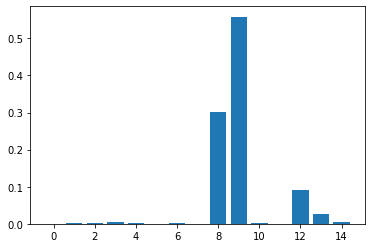

In [24]:
# ploting feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [25]:
#converting types
from datetime import datetime

data[['rcvTime','sendTime']]  = data[['rcvTime','sendTime']].apply(pd.to_datetime)
data[['sender','messageID']]  = data[['sender','messageID']].fillna(0.0).astype(int)

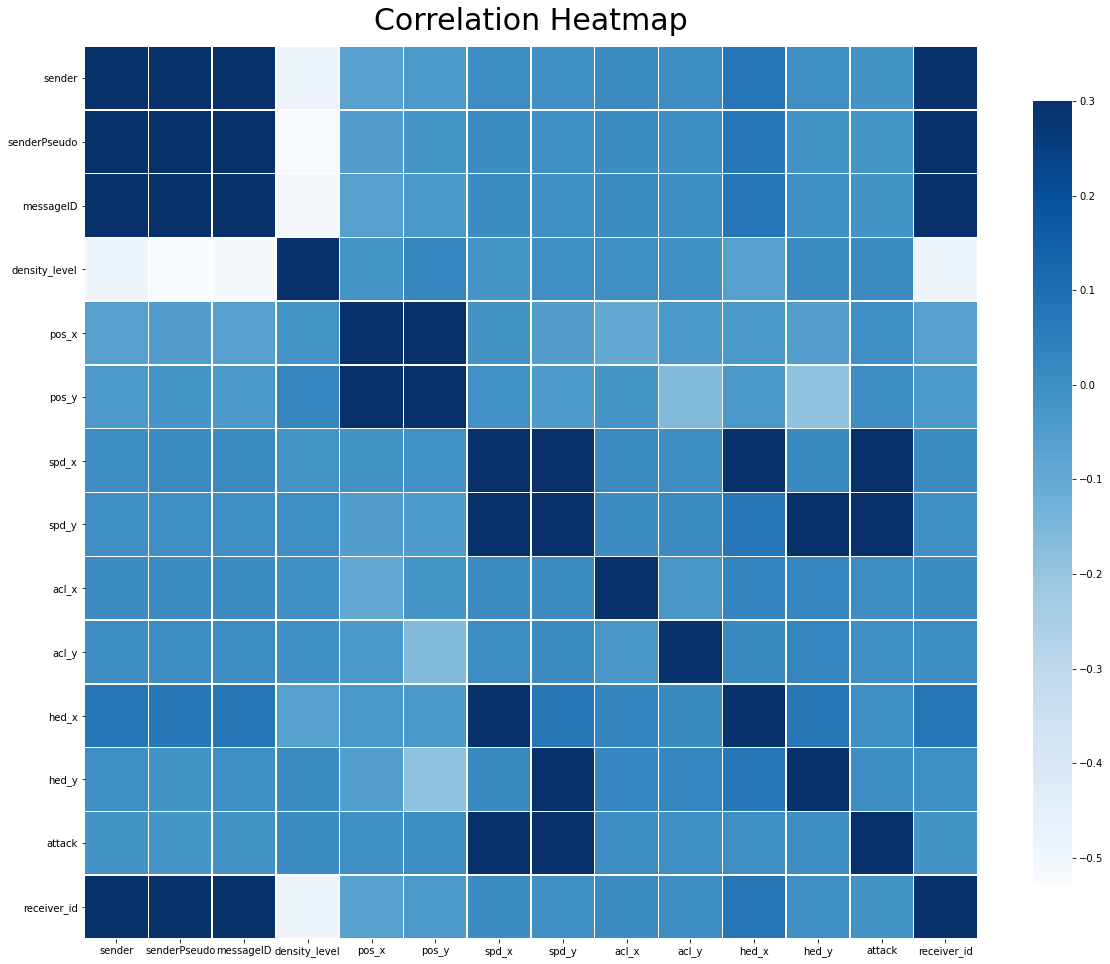

In [26]:
plt.figure(figsize=(20, 18))

mask = np.triu(np.zeros_like(data.corr(), dtype=np.bool)) # # define the mask to set the values in the upper triangle to True

heatmap = sns.heatmap(data.corr(), mask=mask, vmax=.3, square=True,linewidths=.5, cmap='Blues',cbar_kws={"shrink": .8})

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=16);


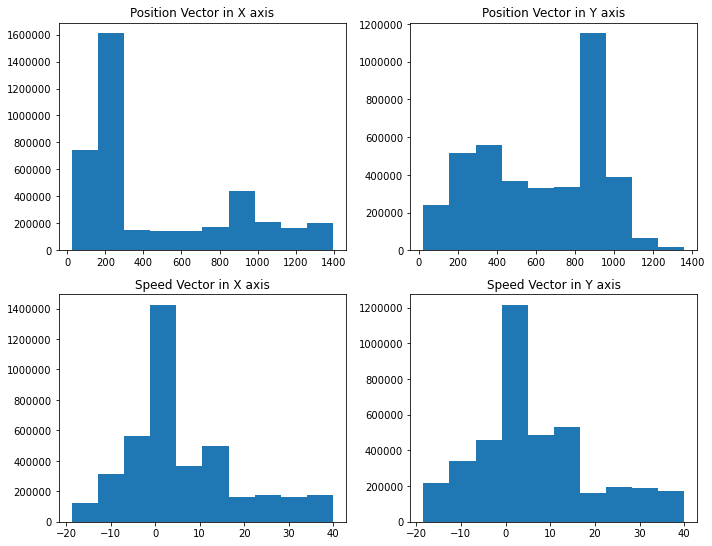

In [27]:
plt.figure(figsize=(10,15))
plt.subplot(4,2,1)
plt.hist(data['pos_x'])
plt.ticklabel_format(style='plain')
plt.title('Position Vector in X axis')
plt.subplot(4,2,2)
plt.hist(data['pos_y'])
plt.ticklabel_format(style='plain')
plt.title('Position Vector in Y axis')
plt.subplot(4,2,3)
plt.hist(data['spd_x'])
plt.ticklabel_format(style='plain')
plt.title('Speed Vector in X axis')
plt.subplot(4,2,4)
plt.hist(data['spd_y'])
plt.ticklabel_format(style='plain')
plt.title('Speed Vector in Y axis')
plt.tight_layout()
plt.show()


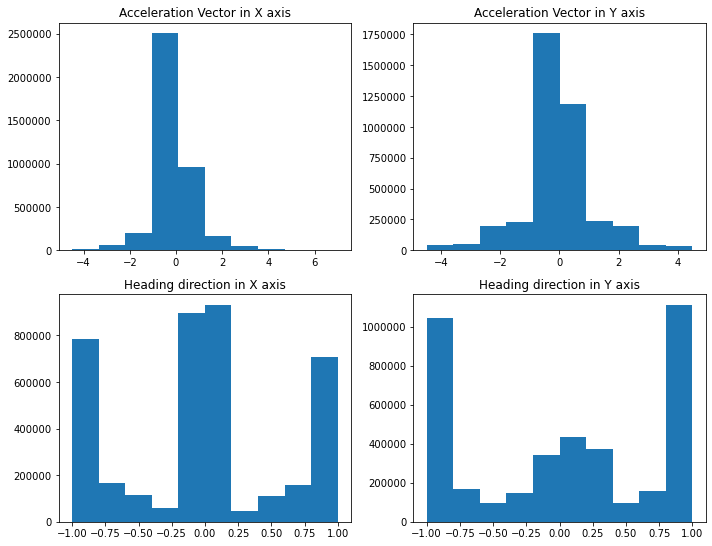

In [28]:
plt.figure(figsize=(10,15))
plt.subplot(4,2,1)
plt.hist(data['acl_x'])
plt.ticklabel_format(style='plain')
plt.title('Acceleration Vector in X axis')
plt.subplot(4,2,2)
plt.hist(data['acl_y'])
plt.ticklabel_format(style='plain')
plt.title('Acceleration Vector in Y axis')
plt.subplot(4,2,3)
plt.hist(data['hed_x'])
plt.ticklabel_format(style='plain')
plt.title('Heading direction in X axis')
plt.subplot(4,2,4)
plt.hist(data['hed_y'])
plt.ticklabel_format(style='plain')
plt.title('Heading direction in Y axis')
plt.tight_layout()
plt.show()

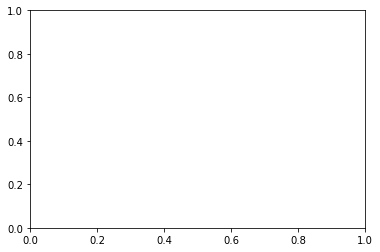

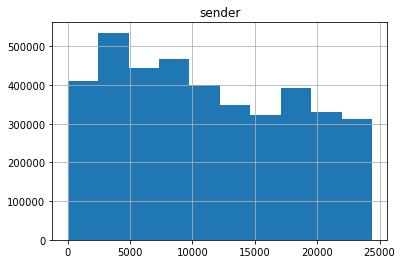

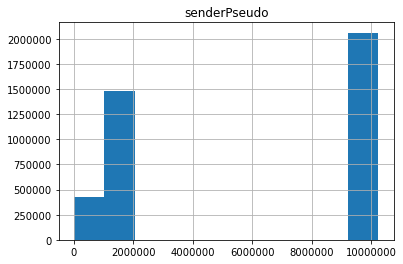

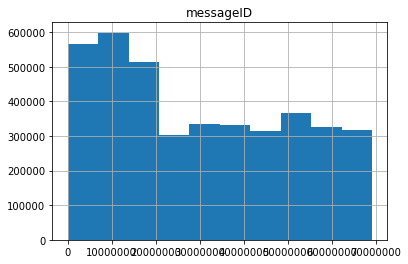

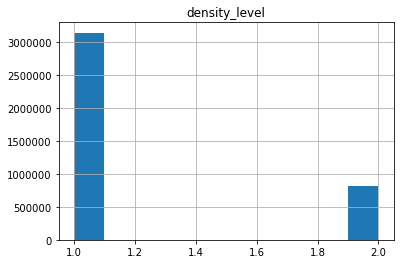

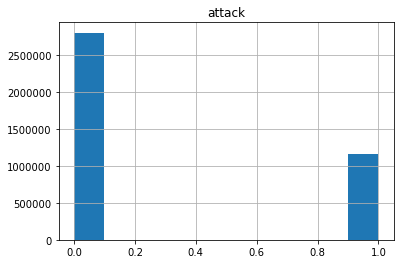

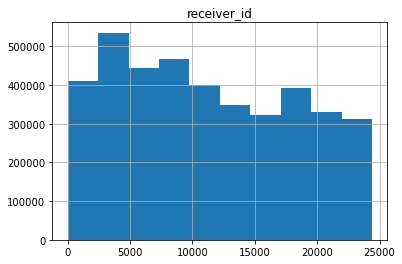

In [29]:
for cols in ['sender', 'senderPseudo', 'messageID','density_level','attack', 'receiver_id']: 
    plt.ticklabel_format(style='plain')
    data.hist(cols)

Text(0, 0.5, 'Position in y-axis')

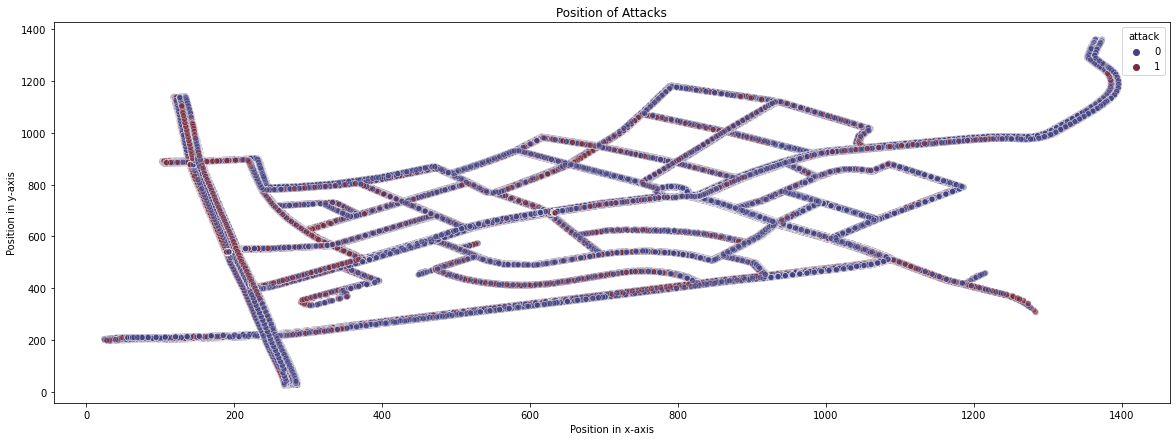

In [30]:

plt.figure(figsize=(20,7))
sns.scatterplot(data['pos_x'],data['pos_y'],hue=data['attack'],palette="icefire",alpha=0.5)
plt.title('Position of Attacks')
plt.xlabel('Position in x-axis')
plt.ylabel('Position in y-axis')


Text(0, 0.5, 'speed in y-axis')

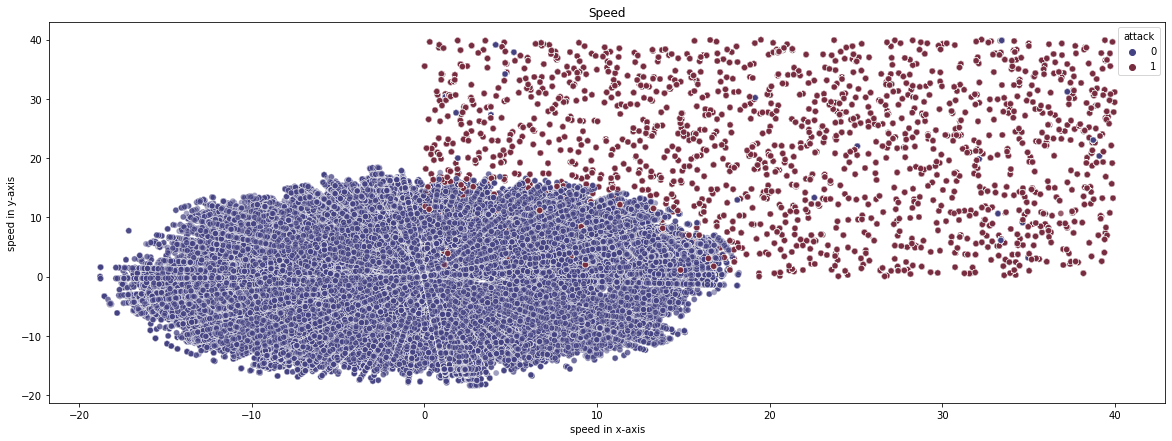

In [31]:
plt.figure(figsize=(20,7))
sns.scatterplot(data['spd_x'],data['spd_y'],hue=data['attack'],palette="icefire",alpha=0.5)
plt.title('Speed')
plt.xlabel('speed in x-axis')
plt.ylabel('speed in y-axis')

Text(0, 0.5, 'Acceleration in y-axis')

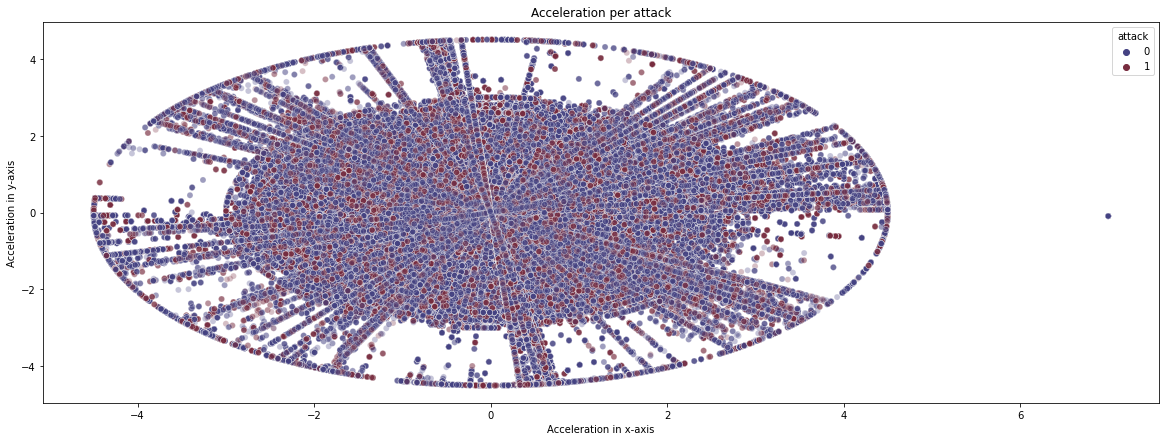

In [32]:
plt.figure(figsize=(20,7))
sns.scatterplot(data['acl_x'],data['acl_y'],hue=data['attack'],palette=('icefire'),alpha=0.3)
plt.title('Acceleration per attack')
plt.xlabel('Acceleration in x-axis')
plt.ylabel('Acceleration in y-axis')

In [17]:
data.columns

Index(['rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID',
       'density_level', 'pos_x', 'pos_y', 'spd_x', 'spd_y', 'acl_x', 'acl_y',
       'hed_x', 'hed_y', 'attack', 'receiver_id', 'file_name'],
      dtype='object')